In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = ""



import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from dcmnet.rdkit_utils import get_mol_from_id


# import pybel

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [174]:
import pandas as pd

In [269]:
mbis = Path("/pchem-data/meuwly/boittier/home/analysis/MBIS")
mbisdata = mbis.glob("*pkl")

In [270]:
data = {_.stem: pd.read_pickle(_) for _ in mbisdata}

In [271]:
# data

In [272]:
# list(data.keys())

In [273]:
data["dsgdb9nsd_128942"]

{'mono': array([-1.23295083e-03, -3.69578099e-04,  1.02163980e-03, ...,
        -7.55053797e-10, -7.55053797e-10, -7.55053797e-10]),
 'dipo': array([-1.63698005e-03, -9.04565183e-04,  3.50989660e-04, ...,
        -7.07874665e-10, -7.07874665e-10, -7.07874665e-10]),
 'quad': array([-1.58911597e-03, -8.31333733e-04,  4.46683927e-04, ...,
        -7.07871231e-10, -7.07871231e-10, -7.07871231e-10]),
 'esp': array([-0.00149051, -0.00068025,  0.00064643, ...,  0.        ,
         0.        ,  0.        ]),
 'closest_atom_type': array([7, 7, 1, ..., 1, 1, 1]),
 'closest_atom': array([ 0,  0,  9, ..., 12, 12, 12]),
 'mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'rmse_mono': Array(1.7298307, dtype=float32),
 'rmse_dipo': Array(1.5323756, dtype=float32),
 'rmse_quad': Array(1.3855447, dtype=float32),
 'rmse_mono_masked': Array(0.82494813, dtype=float32),
 'rmse_dipo_masked': Array(0.5570156, dtype=float32),
 'rmse_quad_masked': Array(0.4212189, dtype=float32),
 'D_mono': Arra

In [274]:
failed = pd.read_csv("/pchem-data/meuwly/boittier/home/jaxeq/data/qm9-fails.csv")
failed = list(failed["0"])

In [275]:
data = {k:v for k,v in data.items() if k not in failed}

In [276]:
rmse_mono_masked = [float(_["rmse_mono_masked"]) for _ in data.values()]
rmse_dipo_masked = [float(_["rmse_dipo_masked"]) for _ in data.values()]
rmse_quad_masked = [float(_["rmse_quad_masked"]) for _ in data.values()]
D_mae_mono = [float(_["D_mae_mono"]) for _ in data.values()]
D_mae_dipo = [float(_["D_mae_dipo"]) for _ in data.values()]
keys = list(data.keys())
len(keys), len(rmse_mono_masked)

(6506, 6506)

In [316]:
mbis_df = pd.DataFrame({"id": keys, 
                        "rmse_mono_masked": rmse_mono_masked,
                       "rmse_dipo_masked": rmse_dipo_masked,
                        "rmse_quad_masked": rmse_quad_masked,
                        "D_mae_mono": D_mae_mono,
                        "D_mae_dipo": D_mae_dipo,
                       })
mbis_df.describe()

,rmse_mono_masked,rmse_dipo_masked,rmse_quad_masked,D_mae_mono,D_mae_dipo
count,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000
mean,1.098358,0.662090,0.492402,0.194850,0.000882
std,0.337707,0.172121,0.108029,0.099033,0.000427
min,0.328302,0.225493,0.187964,0.000123,0.000002
25%,0.861784,0.542595,0.419100,0.122613,0.000567
50%,1.035795,0.645284,0.482970,0.181789,0.000834
75%,1.287192,0.757990,0.550798,0.253889,0.001148
max,2.938473,1.538716,1.061774,0.652840,0.005202


In [188]:
analysis_dirs = list(Path("/pchem-data/meuwly/boittier/home/analysis/").glob("202410*dcm*"))
# mbisdata = mbis.glob("*pkl")

In [189]:
for i, _ in enumerate(analysis_dirs):
    print(i, _)

0 /pchem-data/meuwly/boittier/home/analysis/20241002-180908dcm-4-w-10000
1 /pchem-data/meuwly/boittier/home/analysis/20241002-174336dcm-3-w-10000
2 /pchem-data/meuwly/boittier/home/analysis/20241002-175338dcm-2-w-10000
3 /pchem-data/meuwly/boittier/home/analysis/20241002-174336dcm-2-w-10000
4 /pchem-data/meuwly/boittier/home/analysis/20241002-180732dcm-3-w-10000
5 /pchem-data/meuwly/boittier/home/analysis/20241002-180916dcm-2-w-10000
6 /pchem-data/meuwly/boittier/home/analysis/20241002-180941dcm-2-w-10000
7 /pchem-data/meuwly/boittier/home/analysis/20241002-180943dcm-4-w-10000
8 /pchem-data/meuwly/boittier/home/analysis/20241002-180930dcm-4-w-10000
9 /pchem-data/meuwly/boittier/home/analysis/20241002-180931dcm-3-w-10000
10 /pchem-data/meuwly/boittier/home/analysis/20241002-182242dcm-4-w-10000
11 /pchem-data/meuwly/boittier/home/analysis/20241002-182301dcm-3-w-10000


In [190]:
pickles = [list(_.glob("*pkl")) for _ in analysis_dirs]

In [332]:
pd.read_pickle(pickles[0][0]).keys()

dict_keys(['mono', 'dipo', 'D_xyz_pred', 'D_mae', 'esp_pred', 'mask', 'closest_atom_type', 'rmse_model', 'rmse_model_masked'])

In [362]:
names = [analysis_dirs[i].stem for i in range(len(analysis_dirs))]
n = 11

100%|█████████████████████████████████████████████████████████████████████████████████████████| 6785/6785 [00:38<00:00, 176.40it/s]


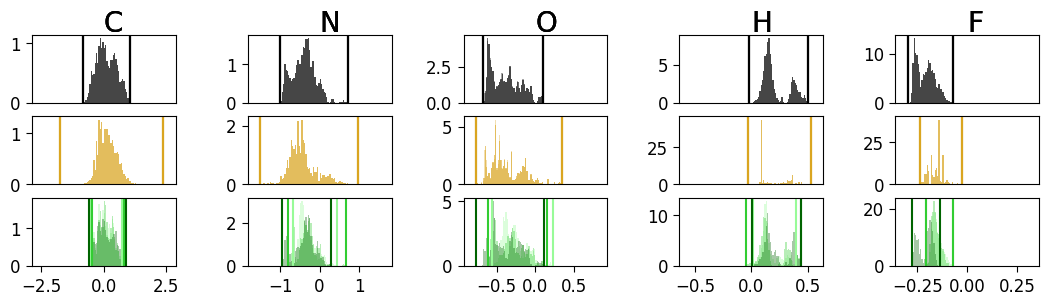

In [404]:
charge_comparison = pd.read_csv("charge-comparison.csv")

colors_m = {2: "palegreen", 11: "limegreen", 10: "darkgreen" }

fig, axes = plt.subplots(3,5, figsize=(13,3))
plt.subplots_adjust(wspace=0.5)

for n in [2,11,10]:

    colors = {"mbis_q": "k", "cgenff_q": "goldenrod", names[n]: colors_m[n]}
    
    charge_data = []
    for i in tqdm(range(len(pickles[n]))):
        test_pkl = pickles[n][i]
        key = test_pkl.stem
        test_data = pd.read_pickle(test_pkl)
        
        query = charge_comparison[charge_comparison["qm9_id"] == key]
        qs = test_data["mono"].sum(axis=-1)[:,:len(query)].flatten()
        query[names[n]] = qs
        charge_data.append(query)
    
    test_charges = pd.concat(charge_data)
    
    for i, e in enumerate(test_charges.element.unique()):
        q_keys = ["mbis_q", "cgenff_q", names[n]]
        tmp = test_charges[test_charges["element"] == e]
        min_ = min([tmp[k].min() for k in q_keys]) * 1.1
        max_ = max([tmp[k].max() for k in q_keys]) * 1.1
        max_ = max([abs(min_), abs(max_)])
        for j, k in enumerate(q_keys):
            axes[j,i].hist(tmp[k], bins=100, range=(max_*-1,max_), alpha=0.35, density=True, label=k, color=colors[k])
            axes[j,i].axvline(tmp[k].min(),color=colors[k])
            axes[j,i].axvline(tmp[k].max(),color=colors[k])
            if j < 2:
                axes[j,i].set_xticks([])
        axes[0, i].text(0.5, 1.05, f"{e}", transform=axes[0,i].transAxes, fontsize=20)


In [191]:
def get_df(pickles_list, name):
    data = {_.stem: pd.read_pickle(_) for _ in pickles_list}
    keys = [k for k in list(data.keys()) if k not in failed]
    run = [name for k in keys]
    n_dcm = [int(_.split("-")[2]) for _ in run]
    rmse_masked = [float(data[k]["rmse_model_masked"]) for k in keys]
    D_mae = [float(data[k]["D_mae"]) for k in keys]
    
    df = pd.DataFrame({"id": keys, "run": run , "n_dcm": n_dcm, "rmse": rmse_masked, "D_mae": D_mae})
    return df

In [333]:
dfs = [get_df(pickles[i], str(analysis_dirs[i].stem)) for i in [2,5,7,9,10,11]]

In [334]:
DFS = pd.concat(dfs)
DFS.groupby("n_dcm").describe()

rmse                                                              \
         count      mean       std       min       25%       50%       75%   
n_dcm                                                                        
2      13012.0  0.828702  0.347256  0.249721  0.633142  0.763267  0.939923   
3      13012.0  0.649717  0.391702  0.185153  0.507767  0.599248  0.720375   
4      13012.0  0.615273  0.269523  0.162104  0.480656  0.559769  0.672150   

                    D_mae                                                   \
             max    count      mean       std       min      25%       50%   
n_dcm                                                                        
2       9.491041  13012.0  0.129293  0.111184  0.001868  0.06763  0.105726   
3      25.625584  13012.0  0.107171  0.120505  0.001096  0.05598  0.087795   
4       7.099349  13012.0  0.105000  0.091757  0.001173  0.05416  0.086030   

                           
            75%       max  
n_dcm                      
2      0.161341  2.886050  
3      0.130679  7.525001  
4      0.130066  2.662441

Text(0.5, 0, 'RMSE$_{\\mathrm{ESP}}$ [(kcal/mol)/$e$]')

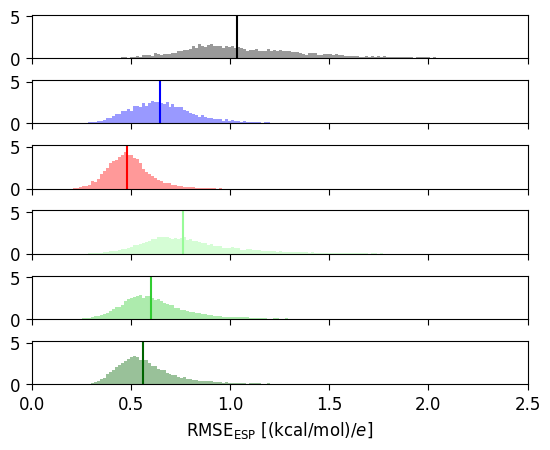

In [407]:
fig, axes = plt.subplots(6,1, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)

axes[0].hist(mbis_df["rmse_mono_masked"], bins=200, range=(0,3), alpha=0.4, density=True, color="k")
axes[0].axvline(mbis_df["rmse_mono_masked"].median(), color="k")
axes[1].hist(mbis_df["rmse_dipo_masked"], bins=200, range=(0,3), alpha=0.4, density=True, color="b")
axes[1].axvline(mbis_df["rmse_dipo_masked"].median(), color="b")
axes[2].hist(mbis_df["rmse_quad_masked"], bins=200, range=(0,3), alpha=0.4, density=True, color="r")
axes[2].axvline(mbis_df["rmse_quad_masked"].median(), color="r")

colors_m = {2: "palegreen", 3: "limegreen", 4: "darkgreen" }

for i in [2,3,4]:
    tmpdf = DFS[DFS["n_dcm"] == i] 
    axes[i+1].hist(tmpdf["rmse"], bins=200, range=(0,3), alpha=0.4, density=True, color=colors_m[i])
    axes[i+1].axvline(tmpdf["rmse"].median(), color=colors_m[i])

for ax in axes:
    ax.set_ylim(0, 5.2)
    ax.set_xlim(0, 2.5)

axes[-1].set_xlabel("RMSE$_{\mathrm{ESP}}$ [(kcal/mol)/$e$]")

In [335]:
DFS.groupby("run")[["rmse", "D_mae"]].describe()

rmse                                          \
                               count      mean       std       min       25%   
run                                                                            
20241002-175338dcm-2-w-10000  6506.0  0.820535  0.328407  0.276403  0.642897   
20241002-180916dcm-2-w-10000  6506.0  0.836868  0.364975  0.249721  0.621647   
20241002-180931dcm-3-w-10000  6506.0  0.660543  0.476082  0.203283  0.514740   
20241002-180943dcm-4-w-10000  6506.0  0.617301  0.282118  0.162104  0.481837   
20241002-182242dcm-4-w-10000  6506.0  0.613246  0.256316  0.255054  0.479262   
20241002-182301dcm-3-w-10000  6506.0  0.638891  0.282836  0.185153  0.501190   

                                                              D_mae            \
                                   50%       75%        max   count      mean   
run                                                                             
20241002-175338dcm-2-w-10000  0.763198  0.915724   6.859966  6506.0  0.125336   
20241002-180916dcm-2-w-10000  0.763486  0.970705   9.491041  6506.0  0.133251   
20241002-180931dcm-3-w-10000  0.606455  0.730574  25.625584  6506.0  0.106399   
20241002-180943dcm-4-w-10000  0.560550  0.672361   6.129375  6506.0  0.107692   
20241002-182242dcm-4-w-10000  0.558707  0.671158   7.099349  6506.0  0.102309   
20241002-182301dcm-3-w-10000  0.591586  0.709004   8.883291  6506.0  0.107944   

                                                                      \
                                   std       min       25%       50%   
run                                                                    
20241002-175338dcm-2-w-10000  0.111854  0.002605  0.066147  0.102858   
20241002-180916dcm-2-w-10000  0.110378  0.001868  0.069030  0.108476   
20241002-180931dcm-3-w-10000  0.142555  0.001096  0.055765  0.086975   
20241002-180943dcm-4-w-10000  0.095386  0.002186  0.055814  0.088877   
20241002-182242dcm-4-w-10000  0.087904  0.001173  0.052717  0.083141   
20241002-182301dcm-3-w-10000  0.093391  0.001145  0.056272  0.088648   

                                                  
                                   75%       max  
run                                               
20241002-175338dcm-2-w-10000  0.154545  2.381048  
20241002-180916dcm-2-w-10000  0.167766  2.886050  
20241002-180931dcm-3-w-10000  0.127981  7.525001  
20241002-180943dcm-4-w-10000  0.132289  2.104301  
20241002-182242dcm-4-w-10000  0.127667  2.662441  
20241002-182301dcm-3-w-10000  0.133190  2.282175

In [336]:
DFS.run.unique()

array(['20241002-175338dcm-2-w-10000', '20241002-180916dcm-2-w-10000',
       '20241002-180943dcm-4-w-10000', '20241002-180931dcm-3-w-10000',
       '20241002-182242dcm-4-w-10000', '20241002-182301dcm-3-w-10000'],
      dtype=object)